# NWB Tutorial - Optical Physiology

## Introduction
In this tutorial, we will create an NWB file for a hypothetical optical physiology experiment with a freely moving animal. The types of data we will convert are:
* Subject (species, strain, age, etc.)
* Animal position
* Trials
* Acquired two-photon images
* Image segmentation (ROIs)
* Fluorescence and dF/F responses

## Installing PyNWB
First, install PyNWB using pip or conda. You will need Python 3.5+ installed.
- `pip install pynwb`
- `conda install -c conda-forge pynwb`

## Set up the NWB file
An NWB file represents a single session of an experiment. Each file must have a session description, identifier, and session start time. Create a new `NWBFile` object with those and additional metadata. For all PyNWB constructors, we recommend using keyword arguments.

In [1]:
from pynwb import NWBFile
from datetime import datetime
from dateutil import tz

start_time = datetime(2018, 4, 25, 2, 30, 3, tzinfo=tz.gettz('US/Pacific'))

nwbfile = NWBFile(
    session_description='Mouse exploring an open field',
    identifier='Mouse5_Day3',
    session_start_time=start_time,
    session_id='session_1234',                                # optional
    experimenter='My Name',                                   # optional
    lab='My Lab Name',                                        # optional
    institution='University of My Institution',               # optional
    related_publications='DOI:10.1016/j.neuron.2016.12.011'   # optional
)
print(nwbfile)

root pynwb.file.NWBFile at 0x140463717857296
Fields:
  experimenter: ['My Name']
  file_create_date: [datetime.datetime(2020, 5, 13, 22, 59, 23, 74205, tzinfo=tzlocal())]
  identifier: Mouse5_Day3
  institution: University of My Institution
  lab: My Lab Name
  related_publications: ['DOI:10.1016/j.neuron.2016.12.011']
  session_description: Mouse exploring an open field
  session_id: session_1234
  session_start_time: 2018-04-25 02:30:03-07:00
  timestamps_reference_time: 2018-04-25 02:30:03-07:00



## Subject information
Create a `Subject` object to store information about the experimental subject, such as age, species, genotype, sex, and a freeform description. Then set `nwbfile.subject` to the `Subject` object.

<img src="images/subject.svg" width="150">

Each of these fields is free-form text, so any values will be valid, but here are our recommendations:
- For age, we recommend using the [ISO 8601 Duration format](https://en.wikipedia.org/wiki/ISO_8601#Durations), e.g., P90D for 90 days old
- For species, we recommend using the formal latin binomal name (e.g., mouse: *Mus musculus*, human: *Homo sapiens*)
- For sex, we recommend using F (female), M (male), U (unknown), and O (other)

In [2]:
from pynwb.file import Subject

nwbfile.subject = Subject(
    subject_id='001',
    age='P90D', 
    description='mouse 5',
    species='Mus musculus', 
    sex='M'
)

## SpatialSeries and Position
Many types of data can be stored in specialized classes in NWB. To store the spatial position of an animal, use the `SpatialSeries` and `Position` classes. 

`SpatialSeries` is a subclass of `TimeSeries`. `TimeSeries` is a common base class for measurements sampled over time, and provides fields for data and time (regularly or irregularly sampled).

<img src="images/SpatialSeries.svg" width="200">

Create a `SpatialSeries` object named `'SpatialSeries'` with some fake data.

In [3]:
import numpy as np
from pynwb.behavior import SpatialSeries

# create fake data with shape (50, 2)
# the first dimension should always represent time
position_data = np.array([np.linspace(0, 10, 50),
                          np.linspace(0, 8, 50)]).T
position_timestamps = np.linspace(0, 50) / 200

spatial_series_obj = SpatialSeries(
    name='SpatialSeries', 
    description='(x,y) position in open field',
    data=position_data,
    timestamps=position_timestamps,
    reference_frame='(0,0) is bottom left corner'
)

You can print the `SpatialSeries` object to view its contents.

In [4]:
print(spatial_series_obj)

SpatialSeries pynwb.behavior.SpatialSeries at 0x140462662449104
Fields:
  comments: no comments
  conversion: 1.0
  data: [[ 0.          0.        ]
 [ 0.20408163  0.16326531]
 [ 0.40816327  0.32653061]
 [ 0.6122449   0.48979592]
 [ 0.81632653  0.65306122]
 [ 1.02040816  0.81632653]
 [ 1.2244898   0.97959184]
 [ 1.42857143  1.14285714]
 [ 1.63265306  1.30612245]
 [ 1.83673469  1.46938776]
 [ 2.04081633  1.63265306]
 [ 2.24489796  1.79591837]
 [ 2.44897959  1.95918367]
 [ 2.65306122  2.12244898]
 [ 2.85714286  2.28571429]
 [ 3.06122449  2.44897959]
 [ 3.26530612  2.6122449 ]
 [ 3.46938776  2.7755102 ]
 [ 3.67346939  2.93877551]
 [ 3.87755102  3.10204082]
 [ 4.08163265  3.26530612]
 [ 4.28571429  3.42857143]
 [ 4.48979592  3.59183673]
 [ 4.69387755  3.75510204]
 [ 4.89795918  3.91836735]
 [ 5.10204082  4.08163265]
 [ 5.30612245  4.24489796]
 [ 5.51020408  4.40816327]
 [ 5.71428571  4.57142857]
 [ 5.91836735  4.73469388]
 [ 6.12244898  4.89795918]
 [ 6.32653061  5.06122449]
 [ 6.53061224 

To help data analysis and visualization tools know that this `SpatialSeries` object represents the position of the animal, store the `SpatialSeries` object inside of a `Position` object, which can hold one or more `SpatialSeries` objects.

<img src="images/Position2.svg" width="450">

In [5]:
from pynwb.behavior import Position

position_obj = Position(spatial_series=spatial_series_obj)

NWB differentiates between raw, *acquired data*, which should never change, and *processed data*, which are the results of preprocessing algorithms and could change. Let's assume that the animal's position was computed from a video tracking algorithm, so it would be classified as processed data. Since processed data can be very diverse, NWB allows us to create processing modules, which are like folders, to store related processed data or data that comes from a single algorithm. 

Create a processing module called "behavior" for storing behavioral data in the `NWBFile` and add the `Position` object to the module.

In [6]:
behavior_module = nwbfile.create_processing_module(
    name='behavior', 
    description='processed behavioral data'
)
behavior_module.add(position_obj)

Position pynwb.behavior.Position at 0x140462662447888
Fields:
  spatial_series: {
    SpatialSeries <class 'pynwb.behavior.SpatialSeries'>
  }

<img src="images/Behavior.svg" width="600">

## Write to file

Now, write the NWB file that we have built so far.

In [7]:
from pynwb import NWBHDF5IO

with NWBHDF5IO('ophys_tutorial.nwb', 'w') as io:
    io.write(nwbfile)

We can then read the file and print it to inspect its contents. We can also print the `SpatialSeries` data that we created by referencing the names of the objects in the hierarchy that contain it. The processing module called `'behavior'` contains our `Position` object. By default, the `Position` object is named `'Position'`. The `Position` object contains our `SpatialSeries` object named `'SpatialSeries'`.

In [8]:
with NWBHDF5IO('ophys_tutorial.nwb', 'r') as io:
    read_nwbfile = io.read()
    print(read_nwbfile.processing['behavior']['Position']['SpatialSeries'])

SpatialSeries pynwb.behavior.SpatialSeries at 0x140462662447376
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (50, 2), type "<f8">
  description: (x,y) position in open field
  interval: 1
  reference_frame: (0,0) is bottom left corner
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (50,), type "<f8">
  timestamps_unit: seconds
  unit: meters



We can also use the HDFView tool to inspect the resulting NWB file.

<img src="images/position_hdfview.png" width="400">

## Trials

Trials are stored in a `TimeIntervals` object which is a subclass of `DynamicTable`. `DynamicTable` objects are used to store tabular metadata throughout NWB, including for trials, electrodes, and sorted units. They offer flexibility for tabular data by allowing required columns, optional columns, and custom columns.

<img src="images/trials.svg" width="300">

The trials DynamicTable can be thought of as a table with this structure:

<img src="images/trials_example.png" width="400">

Continue adding to our `NWBFile` by creating a new column for the trials table named `'correct'`, which will be a boolean array.

In [9]:
nwbfile.add_trial_column(name='correct', description='whether the trial was correct')
nwbfile.add_trial(start_time=1.0, stop_time=5.0, correct=True)
nwbfile.add_trial(start_time=6.0, stop_time=10.0, correct=False)

We can view the trials table in tabular form by converting it to a pandas dataframe.

In [10]:
nwbfile.trials.to_dataframe()

,start_time,stop_time,correct
id,,,
0,1.0,5.0,True
1,6.0,10.0,False


## Optical physiology
Optical physiology results are written in four steps:
1. Create imaging plane
2. Add acquired two-photon images
3. Add image segmentation
4. Add fluorescence and dF/F responses

### Imaging Plane
First, we must create an `ImagingPlane` object, which will hold information about the area and method used to collect the optical imaging data. This first requires creation of a `Device` object for the microscope and an `OpticalChannel` object. 

<img src="images/ImagingPlane.svg" width="400">

Create a `Device` named `'Microscope'` in the `NWBFile` object. Then create an `OpticalChannel` named `'OpticalChannel'` and an imaging plane named `'ImagingPlane'`, passing in the `OpticalChannel` object and the `Device` object.

In [11]:
from pynwb.device import Device
from pynwb.ophys import OpticalChannel

device = nwbfile.create_device(
    name='Microscope', 
    description='My two-photon microscope',
    manufacturer='The best microscope manufacturer'
)
optical_channel = OpticalChannel(
    name='OpticalChannel', 
    description='an optical channel', 
    emission_lambda=500.
)
imaging_plane = nwbfile.create_imaging_plane(
    name='ImagingPlane',
    optical_channel=optical_channel,
    imaging_rate=30.,
    description='a very interesting part of the brain',
    device=device,
    excitation_lambda=600.,
    indicator='GFP',
    location='V1',
    grid_spacing=[.01, .01],
    grid_spacing_unit='meters'
)

### Two Photon Series
Now that we have our `ImagingPlane`, we can create a `TwoPhotonSeries` object to hold our raw 2-photon imaging data. Here, we have two options. The first option is to supply the raw image data to PyNWB, using the `data` argument. The other option is the provide a path to the image files. These two options have trade-offs, so it is worth spending time considering how you want to store this data.

<img src="images/TwoPhotonSeries.svg" width="600">

In [12]:
from pynwb.ophys import TwoPhotonSeries

# using internal data. this data will be stored inside the NWB file
image_series1 = TwoPhotonSeries(
    name='TwoPhotonSeries1',
    data=np.ones((1000,100,100)),
    imaging_plane=imaging_plane,
    rate=1.0,
    unit='normalized amplitude'
)

# using external data. just the file paths will be stored inside the NWB file
image_series2 = TwoPhotonSeries(
    name='TwoPhotonSeries2', 
    dimension=[100,100],
    external_file=['images.tiff'], 
    imaging_plane=imaging_plane,
    starting_frame=[0], 
    format='external', 
    starting_time=0.0, 
    rate=1.0
)

Since these 2-photon data are raw, acquired data, rather than putting the `TwoPhotonSeries` objects in a `ProcessingModule` in the `NWBFile`, like for the computed spatial position data earlier, we will add them to the file as acquired data.

In [13]:
nwbfile.add_acquisition(image_series1)
nwbfile.add_acquisition(image_series2)

### Plane Segmentation
The `PlaneSegmentation` class stores the detected regions of interest in the `TwoPhotonSeries` data. `PlaneSegmentation` is a subclass of `DynamicTable`, where each row represents a single region of interest (ROI). 

<img src="images/PlaneSegmentation2.svg" width="400">

The `ImageSegmentation` class can contain multiple `PlaneSegmentation` tables so that we can store the results of different segmentation algorithms or different segmentation classes.

<img src="images/ImageSegmentation.svg" width="700">

Create an `ImageSegmentation` object, and from that object, create a `PlaneSegmentation` tables with a link to the `ImagingPlane` created earlier. Then create a `ProcessingModule` named `'ophys'` to store optical physiology data and add the `ImageSegmentation` to it. This is similar to how we stored the `SpatialSeries` object inside of a `Position` object and stored the `Position` object in a `ProcessingModule` named `'behavior'` earlier.

In [14]:
from pynwb.ophys import ImageSegmentation

img_seg = ImageSegmentation()
ps = img_seg.create_plane_segmentation(
    name='PlaneSegmentation',
    description='output from segmenting my favorite imaging plane',
    imaging_plane=imaging_plane,
    reference_images=image_series1  # optional
)
ophys_module = nwbfile.create_processing_module(
    name='ophys', 
    description='optical physiology processed data'
)
ophys_module.add(img_seg)

ImageSegmentation pynwb.ophys.ImageSegmentation at 0x140462653773008
Fields:
  plane_segmentations: {
    PlaneSegmentation <class 'pynwb.ophys.PlaneSegmentation'>
  }

### Regions Of Interest (ROIs)
#### Image masks
You may add ROIs to the `PlaneSegmentation` table using an image mask or a pixel mask. An image mask is an array that is the same size as a single frame of the `TwoPhotonSeries` that indicates the mask weight of each pixel in the image. Image mask values (weights) may be boolean or continuous between 0 and 1.

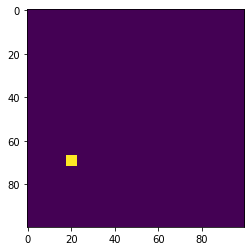

In [15]:
for _ in range(30):
    image_mask = np.zeros((100, 100))
    
    # randomly generate example image masks
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)
    image_mask[x:x+5, y:y+5] = 1
    
    # add image mask to plane segmentation
    ps.add_roi(image_mask=image_mask)
    
# show one of the image masks
import matplotlib.pyplot as plt
plt.imshow(image_mask)

#### Pixel masks
Alternatively, you could define ROIs using a pixel mask, which is an array of triplets (x, y, weight) that have a non-zero weight. All undefined pixels are assumed to be 0. Whichever method you choose to define ROIs -- image mask or pixel mask, you need to be consistent within a `PlaneSegmentation` table; you cannot add some ROIs using `image_mask` and some using `pixel_mask`.

In [16]:
ps2 = img_seg.create_plane_segmentation(
    name='PlaneSegmentation2',
    description='output from segmenting my favorite imaging plane',
    imaging_plane=imaging_plane,
    reference_images=image_series1  # optional
)

for _ in range(30):
    # randomly generate example image masks
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)
    
    pixel_mask = []
    for ix in range(x, x+5):
        for iy in range(y, y+5):
            pixel_mask.append((ix, iy, 1))
    
    # add pixel mask to plane segmentation
    ps2.add_roi(pixel_mask=pixel_mask)

We can view the `PlaneSegmentation` table with pixel masks in tabular form by converting it to a pandas dataframe.

In [17]:
ps2.to_dataframe()

,pixel_mask
id,
0,"[(36, 80, 1), (36, 81, 1), (36, 82, 1), (36, 8..."
1,"[(28, 8, 1), (28, 9, 1), (28, 10, 1), (28, 11,..."
2,"[(13, 94, 1), (13, 95, 1), (13, 96, 1), (13, 9..."
3,"[(92, 35, 1), (92, 36, 1), (92, 37, 1), (92, 3..."
4,"[(63, 65, 1), (63, 66, 1), (63, 67, 1), (63, 6..."
5,"[(62, 79, 1), (62, 80, 1), (62, 81, 1), (62, 8..."
6,"[(94, 28, 1), (94, 29, 1), (94, 30, 1), (94, 3..."
7,"[(22, 11, 1), (22, 12, 1), (22, 13, 1), (22, 1..."
8,"[(25, 80, 1), (25, 81, 1), (25, 82, 1), (25, 8..."


## Storing fluorescence measurements

Now that ROIs are stored, you can store fluorescence data for these ROIs. These type of data are stored using the `RoiResponseSeries` and `Fluorescence` classes, which work similarly to the `SpatialSeries` and `Position` classes, except these are specialized for optical physiology data.

<img src="images/RoiResponseSeries2.svg" width="600">

To create an `RoiResponseSeries` object, we will need to reference a set of rows from a `PlaneSegmentation` table to indicate which ROIs correspond to which rows of your recorded data matrix. This is done using a `DynamicTableRegion`, which is a type of link that allows you to reference specific rows of a `DynamicTable`, such as a `PlaneSegmentation` table, by row indices. 

Create a `DynamicTableRegion` that references the first two ROIs of the `PlaneSegmentation` table.

In [18]:
rt_region = ps.create_roi_table_region(
    region=[0,1],
    description='the first of two ROIs'
)

Then create a `RoiResponseSeries` object to hold fluorescence data for those two ROIs.

In [19]:
from pynwb.ophys import RoiResponseSeries

roi_resp_series = RoiResponseSeries(
    name='RoiResponseSeries',
    data=np.ones((50,2)),  # 50 samples, 2 rois
    rois=rt_region,
    unit='lumens',
    rate=30.
)

To help data analysis and visualization tools know that this `RoiResponseSeries` object represents fluorescence data, store the `RoiResponseSeries` object inside of a `Fluorescence` object. Then place the `Fluorescence` object into the same `ProcessingModule` named `'ophys'` that we created earlier. 

<img src="images/Fluorescence.png" width="800">

In [20]:
from pynwb.ophys import Fluorescence

fl = Fluorescence(roi_response_series=roi_resp_series)
ophys_module.add(fl)

Fluorescence pynwb.ophys.Fluorescence at 0x140462653787984
Fields:
  roi_response_series: {
    RoiResponseSeries <class 'pynwb.ophys.RoiResponseSeries'>
  }

If you want to store dF/F data instead of fluorescence data, then store the `RoiResponseSeries` object in a `DfOverF` object instead of a `Fluorescence` object. The `DfOverF` class works the same way as the `Fluorescence` class. 

## Write the file

In [21]:
with NWBHDF5IO('ophys_tutorial.nwb', 'w') as io:
    io.write(nwbfile)

## Reading NWB data
Data arrays are read passively from the file. Calling `TimeSeries.data` does not read the data values, but presents an `h5py` object that can be indexed to read data. Index this array just like a numpy array to read only a specific section of the array, or use the `[:]` operator to read the entire thing.

In [22]:
with NWBHDF5IO('ophys_tutorial.nwb', 'r') as io:
    read_nwbfile = io.read()

    print(read_nwbfile.acquisition['TwoPhotonSeries1'])
    print(read_nwbfile.processing['ophys']['Fluorescence']['RoiResponseSeries'].data[:])

TwoPhotonSeries1 pynwb.ophys.TwoPhotonSeries at 0x140462510337424
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1000, 100, 100), type "<f8">
  description: no description
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x140462565823056
Fields:
  conversion: 1.0
  description: a very interesting part of the brain
  device: Microscope pynwb.device.Device at 0x140462569306448
  excitation_lambda: 600.0
  imaging_rate: 30.0
  indicator: GFP
  location: V1
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  rate: 1.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: normalized amplitude

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1.

# Learn more!

## Python tutorials
### See our tutorials for more details about your data type:
* [Extracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ecephys.html#sphx-glr-tutorials-domain-ecephys-py)
* [Calcium imaging](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ophys.html#sphx-glr-tutorials-domain-ophys-py)
* [Intracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/icephys.html#sphx-glr-tutorials-domain-icephys-py)

### Check out other tutorials that teach advanced NWB topics:
* [Iterative data write](https://pynwb.readthedocs.io/en/stable/tutorials/general/iterative_write.html#sphx-glr-tutorials-general-iterative-write-py)
* [Extensions](https://pynwb.readthedocs.io/en/stable/tutorials/general/extensions.html#sphx-glr-tutorials-general-extensions-py)
* [Advanced HDF5 I/O](https://pynwb.readthedocs.io/en/stable/tutorials/general/advanced_hdf5_io.html#sphx-glr-tutorials-general-advanced-hdf5-io-py)


## MATLAB tutorials
* [Extracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ecephys.html)
* [Calcium imaging](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ophys.html)
* [Intracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/icephys.html)